In [1]:
from tensorflow import keras

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# from sklearn.ensemble import RandomForestRegressor

#Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#Optimizers
from keras import optimizers

#Results
from sklearn.metrics import mean_absolute_error 

from matplotlib import pyplot as plt
from datetime import datetime
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.


In [2]:
#Read the csvs into dataframes
train_csv = pd.read_csv('./train.csv')
test_csv = pd.read_csv('./test.csv')
features_csv = pd.read_csv('./features.csv')
stores_csv = pd.read_csv('./stores.csv')

### Preprocessing Training Data

In [3]:
train_csv.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
#Merge the features and store information into the train_csv
train_merged_df = (train_csv.merge(stores_csv, how='left', on='Store')).merge(features_csv, how='left', on = ['Date', 'Store'])
del train_merged_df['IsHoliday_y'] #delete duplicate column
train_merged_df = train_merged_df.rename(columns={"IsHoliday_x": "IsHoliday"})

train_merged_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [6]:
#Fill empty markkdown sales with 0
train_merged_df['MarkDown1'] = train_merged_df['MarkDown1'].fillna(0)
train_merged_df['MarkDown2'] = train_merged_df['MarkDown2'].fillna(0)
train_merged_df['MarkDown3'] = train_merged_df['MarkDown3'].fillna(0)
train_merged_df['MarkDown4'] = train_merged_df['MarkDown4'].fillna(0)
train_merged_df['MarkDown5'] = train_merged_df['MarkDown5'].fillna(0)

train_merged_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106


In [7]:
#Convert date column to datetime data type
train_merged_df['Date'] = pd.to_datetime(train_merged_df['Date'])

#Extract year, month and day from the datestamps
train_merged_df['Year'] = train_merged_df['Date'].dt.year
train_merged_df['Month'] = train_merged_df['Date'].dt.month
train_merged_df['Day'] = train_merged_df['Date'].dt.day

train_merged_df.drop(['Date'], axis=1, inplace=True)

In [ ]:
# merged_df.to_csv(r'.\Merged.csv', index=False)

In [8]:
# Check for rows with na entries
train_merged_df.count()

Store           421570
Dept            421570
Weekly_Sales    421570
IsHoliday       421570
Type            421570
Size            421570
Temperature     421570
Fuel_Price      421570
MarkDown1       421570
MarkDown2       421570
MarkDown3       421570
MarkDown4       421570
MarkDown5       421570
CPI             421570
Unemployment    421570
Year            421570
Month           421570
Day             421570
dtype: int64

In [9]:
#Add two columns - 4-week rolling average ('rolling_4_sales') and previous week sales('t-1_sales')
train_merged_df['rolling_4_sales'] = train_merged_df['Weekly_Sales'].rolling(4).mean()
train_merged_df['t-1_sales'] = train_merged_df['Weekly_Sales'].shift(periods=1, freq=None, axis=0)
train_merged_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,rolling_4_sales,t-1_sales
0,1,1,24924.50,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2,5,NaN,NaN
1,1,1,46039.49,True,A,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,2010,2,12,NaN,24924.50
2,1,1,41595.55,False,A,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,2010,2,19,NaN,46039.49
3,1,1,19403.54,False,A,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,2010,2,26,32990.77,41595.55
4,1,1,21827.90,False,A,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,2010,3,5,32216.62,19403.54


In [11]:
print(train_merged_df.count())
train_merged_df = train_merged_df.dropna(how='any')
print(train_merged_df.count())

Store              421570
Dept               421570
Weekly_Sales       421570
IsHoliday          421570
Type               421570
Size               421570
Temperature        421570
Fuel_Price         421570
MarkDown1          421570
MarkDown2          421570
MarkDown3          421570
MarkDown4          421570
MarkDown5          421570
CPI                421570
Unemployment       421570
Year               421570
Month              421570
Day                421570
rolling_4_sales    421567
t-1_sales          421569
dtype: int64
Store              421567
Dept               421567
Weekly_Sales       421567
IsHoliday          421567
Type               421567
Size               421567
Temperature        421567
Fuel_Price         421567
MarkDown1          421567
MarkDown2          421567
MarkDown3          421567
MarkDown4          421567
MarkDown5          421567
CPI                421567
Unemployment       421567
Year               421567
Month              421567
Day                421567

In [12]:
train_merged_df.dtypes

Store                int64
Dept                 int64
Weekly_Sales       float64
IsHoliday             bool
Type                object
Size                 int64
Temperature        float64
Fuel_Price         float64
MarkDown1          float64
MarkDown2          float64
MarkDown3          float64
MarkDown4          float64
MarkDown5          float64
CPI                float64
Unemployment       float64
Year                 int64
Month                int64
Day                  int64
rolling_4_sales    float64
t-1_sales          float64
dtype: object

### Handling categorical columns - label encoding & one-hot encoding

In [13]:
#Use get_dummies to one-hot encode the 'Type'  and 'IsHoliday' column - one-hot encoding this column as it has >2 unique values
train_encoded_df = pd.get_dummies(train_merged_df, columns=["Type", 'IsHoliday'])

In [14]:
train_encoded_df.head()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Year,Month,Day,rolling_4_sales,t-1_sales,Type_A,Type_B,Type_C,IsHoliday_False,IsHoliday_True
3,1,1,19403.54,151315,46.63,2.561,0.0,0.0,0.0,0.0,...,2010,2,26,32990.7700,41595.55,1,0,0,1,0
4,1,1,21827.90,151315,46.50,2.625,0.0,0.0,0.0,0.0,...,2010,3,5,32216.6200,19403.54,1,0,0,1,0
5,1,1,21043.39,151315,57.79,2.667,0.0,0.0,0.0,0.0,...,2010,3,12,25967.5950,21827.90,1,0,0,1,0
6,1,1,22136.64,151315,54.58,2.720,0.0,0.0,0.0,0.0,...,2010,3,19,21102.8675,21043.39,1,0,0,1,0
7,1,1,26229.21,151315,51.45,2.732,0.0,0.0,0.0,0.0,...,2010,3,26,22809.2850,22136.64,1,0,0,1,0


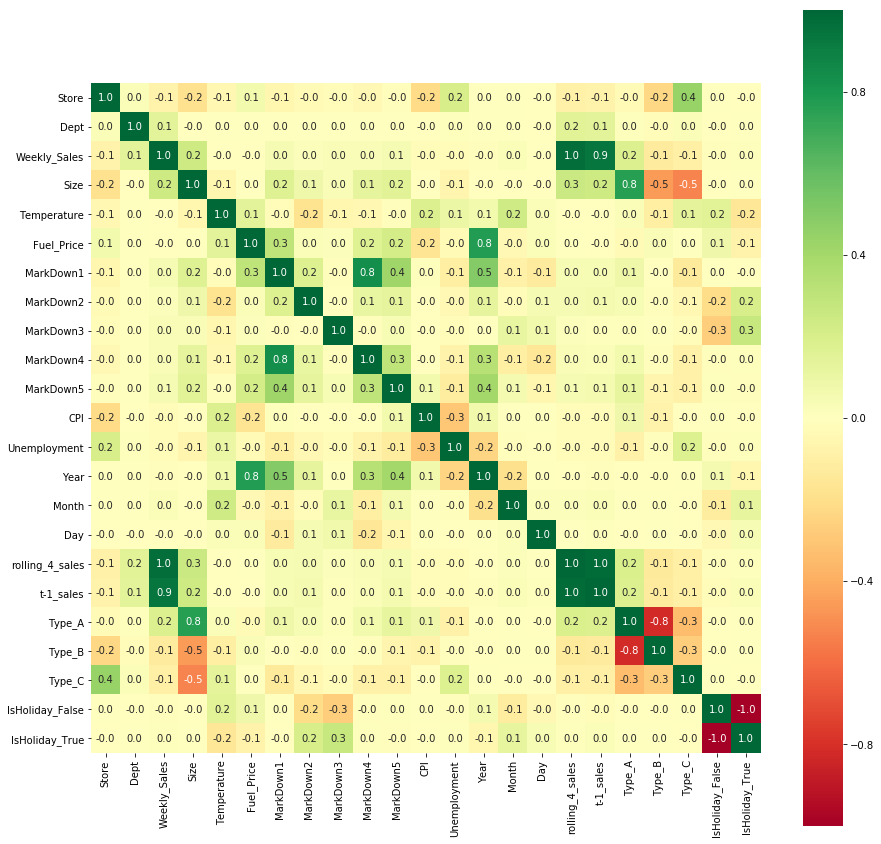

In [15]:
C_mat = train_encoded_df.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmin =-1, vmax = 1, square=True, cmap='RdYlGn', annot=True, fmt='.1f')
plt.show()

### Split the features and target

In [16]:
y_train = train_encoded_df['Weekly_Sales'].values
y_train = y_train.reshape(-1,1)
X_train = train_encoded_df.drop('Weekly_Sales', axis=1)
feature_names = X_train.columns

### Scale and transform the data

In [17]:
X_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train)

X_train_scaled = X_scaler.transform(X_train)
y_train_scaled = y_scaler.transform(y_train)

### Neural Network

In [18]:
#Create a normal sequential neural network
nn_model = Sequential()
nn_model.add(Dense(units=32, kernel_initializer='normal', activation='relu', input_dim=len(X_train.columns))) # hidden and input layers
nn_model.add(Dense(units=1, kernel_initializer='normal',activation='linear')) # output layer
nn_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                736       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 18s - loss: 0.0028 - mean_absolute_error: 0.0028
Epoch 2/50
 - 17s - loss: 0.0026 - mean_absolute_error: 0.0026
Epoch 3/50
 - 17s - loss: 0.0026 - mean_absolute_error: 0.0026
Epoch 4/50
 - 17s - loss: 0.0025 - mean_absolute_error: 0.0025
Epoch 5/50
 - 17s - loss: 0.0025 - mean_absolute_error: 0.0025
Epoch 6/50
 - 17s - loss: 0.0025 - mean_absolute_error: 0.0025
Epoch 7/50
 - 17s - loss: 0.0025 - mean_absolute_error: 0.0025
Epoch 8/50
 - 17s - loss: 0.0025 - mean_absolute_error: 0.0025
Epoch 9/50
 - 17s - loss: 0.0025 - mean_absolute_error: 0.0025
Epoch 10/50
 - 17s - loss: 0.0025 - mean_absolute_error: 0.0025
Epoch 11/50
 - 17s - loss: 0.0025 - mean_absolute_error: 0.0025
Epoch 12/50
 - 11s - loss: 0.0025 - mean_absolute_error: 0.0025
Epoch 13/50
 - 11s - loss: 0.0025 - mean_absolute_error: 0.0025
Epoch 14/50
 - 10s - loss: 0.0025 - mean_absolute_error: 0.0025
Epoch 15/50
 - 10s - loss: 0.0025 - mean_absolute_error: 0.0025
E

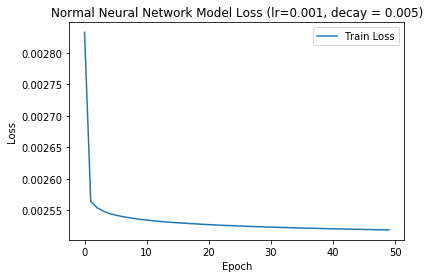

In [19]:
opt = optimizers.Adam(lr=0.001, decay = 0.005)

nn_model.compile(optimizer= opt,
                loss='mean_absolute_error',
                metrics=['mean_absolute_error'])
    
nn_model_var = nn_model.fit(
                X_train_scaled,
                y_train_scaled,
                epochs=50,
                verbose=2)

plt.plot(nn_model_var.history['loss'])
plt.title('Normal Neural Network Model Loss (lr=0.001, decay = 0.005)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss'], loc='upper right')
plt.show()

Epoch 1/50
 - 11s - loss: 0.0029 - mean_absolute_error: 0.0029
Epoch 2/50
 - 10s - loss: 0.0027 - mean_absolute_error: 0.0027
Epoch 3/50
 - 11s - loss: 0.0026 - mean_absolute_error: 0.0026
Epoch 4/50
 - 11s - loss: 0.0025 - mean_absolute_error: 0.0025
Epoch 5/50
 - 11s - loss: 0.0025 - mean_absolute_error: 0.0025
Epoch 6/50
 - 11s - loss: 0.0025 - mean_absolute_error: 0.0025
Epoch 7/50
 - 10s - loss: 0.0025 - mean_absolute_error: 0.0025
Epoch 8/50
 - 11s - loss: 0.0025 - mean_absolute_error: 0.0025
Epoch 9/50
 - 10s - loss: 0.0025 - mean_absolute_error: 0.0025
Epoch 10/50
 - 10s - loss: 0.0025 - mean_absolute_error: 0.0025
Epoch 11/50
 - 12s - loss: 0.0025 - mean_absolute_error: 0.0025
Epoch 12/50
 - 11s - loss: 0.0025 - mean_absolute_error: 0.0025
Epoch 13/50
 - 10s - loss: 0.0025 - mean_absolute_error: 0.0025
Epoch 14/50
 - 10s - loss: 0.0025 - mean_absolute_error: 0.0025
Epoch 15/50
 - 11s - loss: 0.0025 - mean_absolute_error: 0.0025
Epoch 16/50
 - 10s - loss: 0.0025 - mean_absolute

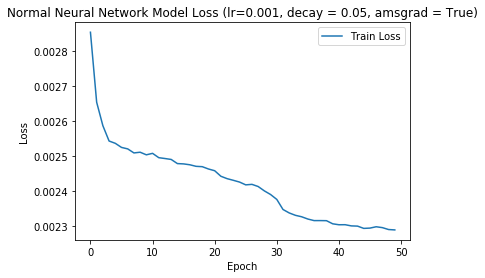

In [20]:
opt = optimizers.Adam(lr=0.001, decay = 0.05, amsgrad = True)

nn_model.compile(optimizer= 'adam',
                loss='mean_absolute_error',
                metrics=['mean_absolute_error'])
    
nn_model_var = nn_model.fit(
                X_train_scaled,
                y_train_scaled,
                epochs=50,
                verbose=2)

plt.plot(nn_model_var.history['loss'])
plt.title('Normal Neural Network Model Loss (lr=0.001, decay = 0.05, amsgrad = True)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss'], loc='upper right')
plt.show()

In [21]:
nn_model_train_loss, nn_model_train_accuracy = nn_model.evaluate(
    X_train_scaled, y_train_scaled, verbose=2)
print(
    f"Normal Neural Network Evaluation - Train Loss: {nn_model_train_loss}, Train Accuracy: {nn_model_train_accuracy}")

Normal Neural Network Evaluation - Train Loss: 0.0022003502029077932, Accuracy: 0.0022003502029077932


In [ ]:
# y_predicted_nn = nn_model.predict(X_test_scaled)

# MAE = mean_absolute_error(y_test_scaled , y_predicted_nn)
# MAE

### Deep Neural Network

In [22]:
dnn_model = Sequential()
dnn_model.add(Dense(units=32, kernel_initializer='normal', activation='relu', input_dim=len(X_train.columns))) # hidden and input layers
dnn_model.add(Dense(units=64, kernel_initializer='normal', activation='relu')) # hidden and input layers
dnn_model.add(Dense(units=128, kernel_initializer='normal', activation='relu')) # hidden and input layers
dnn_model.add(Dense(units=1, kernel_initializer='normal',activation='linear')) # output layer

dnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                736       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 11,297
Trainable params: 11,297
Non-trainable params: 0
_________________________________________________________________


In [23]:
#Define a checkpoint callback
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

Train on 282449 samples, validate on 139118 samples
Epoch 1/50
 - 13s - loss: 0.0033 - mean_absolute_error: 0.0033 - val_loss: 0.0065 - val_mean_absolute_error: 0.0065

Epoch 00001: val_loss improved from inf to 0.00653, saving model to Weights-001--0.00653.hdf5
Epoch 2/50
 - 13s - loss: 0.0029 - mean_absolute_error: 0.0029 - val_loss: 0.0063 - val_mean_absolute_error: 0.0063

Epoch 00002: val_loss improved from 0.00653 to 0.00632, saving model to Weights-002--0.00632.hdf5
Epoch 3/50
 - 13s - loss: 0.0028 - mean_absolute_error: 0.0028 - val_loss: 0.0064 - val_mean_absolute_error: 0.0064

Epoch 00003: val_loss did not improve from 0.00632
Epoch 4/50
 - 12s - loss: 0.0028 - mean_absolute_error: 0.0028 - val_loss: 0.0063 - val_mean_absolute_error: 0.0063

Epoch 00004: val_loss improved from 0.00632 to 0.00627, saving model to Weights-004--0.00627.hdf5
Epoch 5/50
 - 12s - loss: 0.0028 - mean_absolute_error: 0.0028 - val_loss: 0.0063 - val_mean_absolute_error: 0.0063

Epoch 00005: val_loss 

 - 13s - loss: 0.0028 - mean_absolute_error: 0.0028 - val_loss: 0.0062 - val_mean_absolute_error: 0.0062

Epoch 00046: val_loss did not improve from 0.00617
Epoch 47/50
 - 13s - loss: 0.0028 - mean_absolute_error: 0.0028 - val_loss: 0.0062 - val_mean_absolute_error: 0.0062

Epoch 00047: val_loss did not improve from 0.00617
Epoch 48/50
 - 13s - loss: 0.0028 - mean_absolute_error: 0.0028 - val_loss: 0.0062 - val_mean_absolute_error: 0.0062

Epoch 00048: val_loss improved from 0.00617 to 0.00616, saving model to Weights-048--0.00616.hdf5
Epoch 49/50
 - 13s - loss: 0.0028 - mean_absolute_error: 0.0028 - val_loss: 0.0062 - val_mean_absolute_error: 0.0062

Epoch 00049: val_loss did not improve from 0.00616
Epoch 50/50
 - 13s - loss: 0.0028 - mean_absolute_error: 0.0028 - val_loss: 0.0062 - val_mean_absolute_error: 0.0062

Epoch 00050: val_loss did not improve from 0.00616


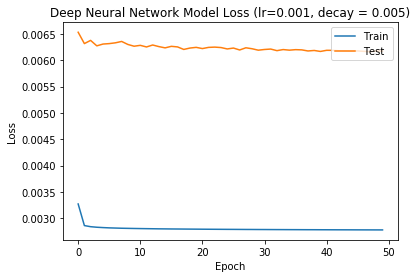

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [24]:
opt = optimizers.Adam(lr=0.001, decay = 0.005)

dnn_model.compile(optimizer=opt,
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])

dnn_model_var = dnn_model.fit(
                        X_train_scaled,
                        y_train_scaled,
                        epochs=50,
                        shuffle=True,
                        verbose=2,
                        batch_size=32, 
                        validation_split = 0.33,
                        callbacks=callbacks_list
                    )

plt.plot(dnn_model_var.history['loss'])
plt.plot(dnn_model_var.history['val_loss'])
plt.title('Deep Neural Network Model Loss (lr=0.001, decay = 0.005)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 282449 samples, validate on 139118 samples
Epoch 1/50
 - 14s - loss: 0.0028 - mean_absolute_error: 0.0028 - val_loss: 0.0062 - val_mean_absolute_error: 0.0062

Epoch 00001: val_loss did not improve from 0.00616
Epoch 2/50
 - 13s - loss: 0.0028 - mean_absolute_error: 0.0028 - val_loss: 0.0062 - val_mean_absolute_error: 0.0062

Epoch 00002: val_loss did not improve from 0.00616
Epoch 3/50
 - 13s - loss: 0.0028 - mean_absolute_error: 0.0028 - val_loss: 0.0062 - val_mean_absolute_error: 0.0062

Epoch 00003: val_loss did not improve from 0.00616
Epoch 4/50
 - 13s - loss: 0.0028 - mean_absolute_error: 0.0028 - val_loss: 0.0062 - val_mean_absolute_error: 0.0062

Epoch 00004: val_loss did not improve from 0.00616
Epoch 5/50
 - 15s - loss: 0.0028 - mean_absolute_error: 0.0028 - val_loss: 0.0062 - val_mean_absolute_error: 0.0062

Epoch 00005: val_loss did not improve from 0.00616
Epoch 6/50
 - 12s - loss: 0.0028 - mean_absolute_error: 0.0028 - val_loss: 0.0062 - val_mean_absolute_error:


Epoch 00044: val_loss did not improve from 0.00611
Epoch 45/50
 - 12s - loss: 0.0028 - mean_absolute_error: 0.0028 - val_loss: 0.0061 - val_mean_absolute_error: 0.0061

Epoch 00045: val_loss did not improve from 0.00611
Epoch 46/50
 - 14s - loss: 0.0028 - mean_absolute_error: 0.0028 - val_loss: 0.0061 - val_mean_absolute_error: 0.0061

Epoch 00046: val_loss did not improve from 0.00611
Epoch 47/50
 - 15s - loss: 0.0028 - mean_absolute_error: 0.0028 - val_loss: 0.0061 - val_mean_absolute_error: 0.0061

Epoch 00047: val_loss did not improve from 0.00611
Epoch 48/50
 - 15s - loss: 0.0028 - mean_absolute_error: 0.0028 - val_loss: 0.0061 - val_mean_absolute_error: 0.0061

Epoch 00048: val_loss did not improve from 0.00611
Epoch 49/50
 - 13s - loss: 0.0028 - mean_absolute_error: 0.0028 - val_loss: 0.0061 - val_mean_absolute_error: 0.0061

Epoch 00049: val_loss improved from 0.00611 to 0.00611, saving model to Weights-049--0.00611.hdf5
Epoch 50/50
 - 13s - loss: 0.0028 - mean_absolute_error:

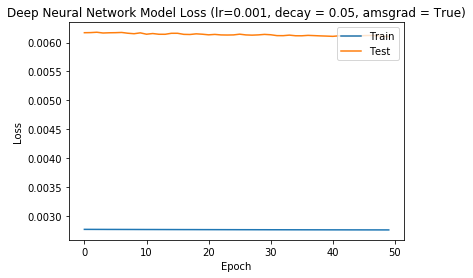

In [26]:
opt = optimizers.Adam(lr=0.001, decay = 0.05, amsgrad = True)

dnn_model_var = dnn_model.fit(
                        X_train_scaled,
                        y_train_scaled,
                        epochs=50,
                        shuffle=True,
                        verbose=2,
                        batch_size=32, 
                        validation_split = 0.33,
                        callbacks=callbacks_list
                    )

plt.plot(dnn_model_var.history['loss'])
plt.plot(dnn_model_var.history['val_loss'])
plt.title('Deep Neural Network Model Loss (lr=0.001, decay = 0.05, amsgrad = True)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 282449 samples, validate on 139118 samples
Epoch 1/50
 - 13s - loss: 0.0032 - mean_absolute_error: 0.0032 - val_loss: 0.0032 - val_mean_absolute_error: 0.0032

Epoch 00001: val_loss improved from 0.00610 to 0.00316, saving model to Weights-001--0.00316.hdf5
Epoch 2/50
 - 13s - loss: 0.0030 - mean_absolute_error: 0.0030 - val_loss: 0.0025 - val_mean_absolute_error: 0.0025

Epoch 00002: val_loss improved from 0.00316 to 0.00253, saving model to Weights-002--0.00253.hdf5
Epoch 3/50
 - 13s - loss: 0.0029 - mean_absolute_error: 0.0029 - val_loss: 0.0026 - val_mean_absolute_error: 0.0026

Epoch 00003: val_loss did not improve from 0.00253
Epoch 4/50
 - 13s - loss: 0.0028 - mean_absolute_error: 0.0028 - val_loss: 0.0025 - val_mean_absolute_error: 0.0025

Epoch 00004: val_loss improved from 0.00253 to 0.00245, saving model to Weights-004--0.00245.hdf5
Epoch 5/50
 - 13s - loss: 0.0028 - mean_absolute_error: 0.0028 - val_loss: 0.0023 - val_mean_absolute_error: 0.0023

Epoch 00005: val_l


Epoch 00048: val_loss did not improve from 0.00228
Epoch 49/50
 - 13s - loss: 0.0024 - mean_absolute_error: 0.0024 - val_loss: 0.0040 - val_mean_absolute_error: 0.0040

Epoch 00049: val_loss did not improve from 0.00228
Epoch 50/50
 - 15s - loss: 0.0024 - mean_absolute_error: 0.0024 - val_loss: 0.0043 - val_mean_absolute_error: 0.0043

Epoch 00050: val_loss did not improve from 0.00228


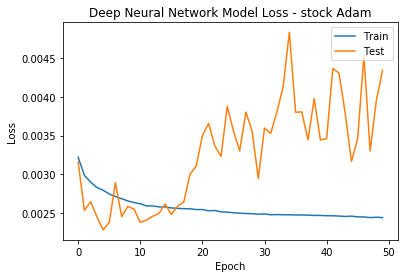

In [29]:
dnn_model.compile(optimizer='adam',
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])

dnn_model_var = dnn_model.fit(
                        X_train_scaled,
                        y_train_scaled,
                        epochs=50,
                        shuffle=True,
                        verbose=2,
                        batch_size=32, 
                        validation_split = 0.33,
                        callbacks=callbacks_list
                    )

plt.plot(dnn_model_var.history['loss'])
plt.plot(dnn_model_var.history['val_loss'])
plt.title('Deep Neural Network Model Loss - stock Adam')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [27]:
dnn_model_train_loss, dnn_model_train_accuracy = dnn_model.evaluate(
    X_train_scaled, y_train_scaled, verbose=2)
print(
    f"Deep Neural Network Evaluation - Train Loss: {dnn_model_train_loss}, Train Accuracy: {dnn_model_train_loss}")

Deep Neural Network Evaluation - Train Loss: 0.0038676319393925163, Train Accuracy: 0.0038676319393925163


In [ ]:
# # Load wights file of the best model :
# wights_file = 'Weights-478--18738.19831.hdf5' # choose the best checkpoint 
# dnn_model.load_weights(wights_file) # load it
# dnn_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [ ]:
# y_predicted_dnn = dnn_model.predict(X_test_scaled)

In [ ]:
# test and train - treat separately from start
#lr (adam), relu (alpha - make it 0.01) dropout, add more layers to dnn (to the power of 2), drop date and don't shuffle
# previous week/ rolling avg of sales (drop first row)
# t-1 and t column
# Try vanilla and stacked LSTMs (shampoo example) https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
#Edit encoded_df to have one-hot columns for dept(99), store(45), year(4), month(12), day(7) and run model again to check accuracy
#Save model

# Predicting results using model for test data

### Preprocessing, One-hot encoding, Features-Target Split, Scaling

In [28]:
#Merge the features and store information into the test_csv
test_merged_df = (test_csv.merge(stores_csv, how='left', on='Store')).merge(features_csv, how='left', on = ['Date', 'Store'])
del test_merged_df['IsHoliday_y'] #delete duplicate column
test_merged_df = test_merged_df.rename(columns={"IsHoliday_x": "IsHoliday"})

#Fill empty markkdown sales with 0
test_merged_df['MarkDown1'] = test_merged_df['MarkDown1'].fillna(0)
test_merged_df['MarkDown2'] = test_merged_df['MarkDown2'].fillna(0)
test_merged_df['MarkDown3'] = test_merged_df['MarkDown3'].fillna(0)
test_merged_df['MarkDown4'] = test_merged_df['MarkDown4'].fillna(0)
test_merged_df['MarkDown5'] = test_merged_df['MarkDown5'].fillna(0)

#Convert date column to datetime data type
test_merged_df['Date'] = pd.to_datetime(test_merged_df['Date'])

#Extract year, month and day from the datestamps
test_merged_df['Year'] = test_merged_df['Date'].dt.year
test_merged_df['Month'] = test_merged_df['Date'].dt.month
test_merged_df['Day'] = test_merged_df['Date'].dt.day

test_merged_df.drop(['Date'], axis=1, inplace=True)

#Add two columns - 4-week rolling average ('rolling_4_sales') and previous week sales('t-1_sales')
test_merged_df['rolling_4_sales'] = test_merged_df['Weekly_Sales'].rolling(4).mean()
test_merged_df['t-1_sales'] = test_merged_df['Weekly_Sales'].shift(periods=1, freq=None, axis=0)

#Use get_dummies to one-hot encode the 'Type'  and 'IsHoliday' column - one-hot encoding this column as it has >2 unique values
test_encoded_df = pd.get_dummies(test_merged_df, columns=["Type", 'IsHoliday'])

# Features-Target Split
y_test = test_encoded_df['Weekly_Sales'].values
y_test = y_test.reshape(-1,1)
X_test = test_encoded_df.drop('Weekly_Sales', axis=1)
feature_names = X_test.columns

#Scaling
X_test_scaled = X_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

KeyError: 'Weekly_Sales'

### Evaluations

In [ ]:
nn_model1_test_loss, nn_model1_test_accuracy = nn_model1.evaluate(
    X_test_scaled, y_test_scaled, verbose=2)
print(
    f"Normal Neural Network Evaluation - Model 1 - Test Loss: {nn_model1_test_loss}, Test Accuracy: {nn_model1_test_accuracy}")

nn_model2_test_loss, nn_model2_test_accuracy = nn_model2.evaluate(
    X_test_scaled, y_test_scaled, verbose=2)
print(
    f"Normal Neural Network Evaluation - Model 2 - Test Loss: {nn_model2_test_loss}, Test Accuracy: {nn_model2_test_accuracy}")

dnn_model1_test_loss, dnn_model1_test_accuracy = dnn_model1.evaluate(
    X_test_scaled, y_test_scaled, verbose=2)
print(
    f"Normal Neural Network Evaluation - Model 1 - Test Loss: {dnn_model1_test_loss}, Test Accuracy: {dnn_model1_test_accuracy}")

dnn_model2_test_loss, dnn_model2_test_accuracy = dnn_model2.evaluate(
    X_test_scaled, y_test_scaled, verbose=2)
print(
    f"Normal Neural Network Evaluation - Model 2 - Test Loss: {dnn_model2_test_loss}, Test Accuracy: {dnn_model2_test_accuracy}")


In [ ]:
y_predicted_nn1 = nn_model1.predict(X_test_scaled)

MAE1 = mean_absolute_error(y_test_scaled , y_predicted_nn1)
MAE1

In [ ]:
y_predicted_nn2 = nn_model2.predict(X_test_scaled)

MAE2 = mean_absolute_error(y_test_scaled , y_predicted_nn2)
MAE2

In [ ]:
y_predicted_dnn1 = dnn_model1.predict(X_test_scaled)

MAE3 = mean_absolute_error(y_test_scaled , y_predicted_dnn1)
MAE3

In [ ]:
y_predicted_dnn2 = dnn_model1.predict(X_test_scaled)

MAE4 = mean_absolute_error(y_test_scaled , y_predicted_dnn2)
MAE4

In [ ]:
#Ravel the arrays
y_test_minmaxscaled = y_test_scaled.ravel()
NN1_predictions = y_predicted_nn1.ravel()
NN2_predictions = y_predicted_nn2.ravel()
DNN1_predictions = y_predicted_dnn1.ravel()
DNN2_predictions = y_predicted_dnn2.ravel()

In [ ]:
#Save y_test and predictions in a dataframe
Predictions_df = pd.DataFrame({"Y Test":y_test_minmaxscaled,
                               "NN 1 Predictions":NN1_predictions,
                               "NN 2 Predictions":NN2_predictions,
                               "DNN 1 Predictions":DNN1_predictions,
                               "DNN 2 Predictions":DNN2_predictions})

#Export dataframe
Predictions_df.to_csv('NN Predictions.csv')